<a id='sec1'></a>
# Expectation Maximization
In statistics, an expectation–maximization (EM) algorithm is an iterative method to find maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables. The EM iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)


<a id='sec2'></a>
# How the EM algorithm works

Please have a look at this short video where it is explained very well on a 1-dimensional example: https://www.youtube.com/watch?v=iQoXFmbXRJA  
  
    
    

![](http://www.wilsonmongwe.co.za/wp-content/uploads/2015/07/400px-EM.jpg)

Below slides explaining with a 2-dimensional example
![alt text](http://i.imgur.com/0cTmOja.png "Logo Title Text 1")

![alt text](http://i.imgur.com/8kQ9aa6.png "Logo Title Text 1")

![alt text](http://i.imgur.com/A1j3lqB.png "Logo Title Text 1")

<a id='sec3'></a>
# Basic example of Expectation Maximization 

Let's try this on a simple basic example.  
Objective: Let's etimate the probability distribution in a 1-dimensional dataset 
*  that we generated ourselves using  2 gaussian normal probability distributions.
*  Using a Gaussian mixture model with 2 normal gaussian distributions

Or in other words, we should be able to find our own mean and standard deviation parameters we used to generate the testset.

Note, this notebook is for building the basic conceptual understanding of the EM algorithm. Not to have the best code, the best computable algorithm, etc. I tried to keep it simple.


In [1]:
# import libraries

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
print("import done")

import done


![](http://)# Generate the data yourself 
Select $\mu_1, \sigma_1$ and $\mu_2, \sigma_2$ to generate the data


Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


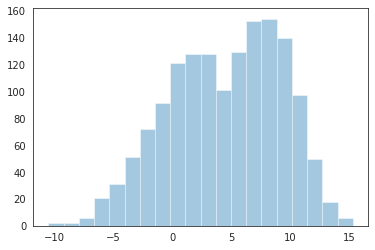

In [2]:
random_seed=36788765
np.random.seed(random_seed)

Mean1 = 2.0  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4.0
Mean2 = 9.0 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2.0

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
sns.distplot(data, bins=20, kde=False);

In [3]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


<a id='sec32'></a>
## A single Gaussion will not fit the data well
Calculating the mean and standard deviation of the dataset shows it does not fit well

Best single Gaussian: μ = 4.4, σ = 4.8


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


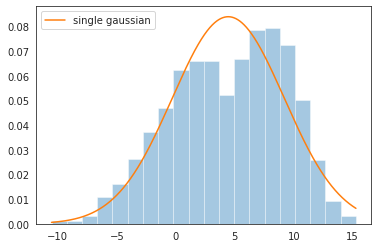

In [4]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True);
plt.plot(x, g_single, label='single gaussian');
plt.legend();

<a id='sec4'></a>
# The code for EM with 2 Gaussian mixture model

In [5]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


<a id='sec41'></a>
## See the algorithm in action

In [6]:
# See the algorithm in action
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass


 1 Mixture: Gaussian(0.746414, 3.04711), Gaussian(8.67166, 2.06257), mix=0.533)
 1 Mixture: Gaussian(0.92499, 3.26546), Gaussian(8.57032, 2.23265), mix=0.539)
 1 Mixture: Gaussian(1.01614, 3.37165), Gaussian(8.51942, 2.30426), mix=0.542)
 1 Mixture: Gaussian(1.07401, 3.43314), Gaussian(8.49444, 2.34), mix=0.545)
 1 Mixture: Gaussian(1.11516, 3.47242), Gaussian(8.48357, 2.35843), mix=0.547)
 1 Mixture: Gaussian(1.14679, 3.49938), Gaussian(8.48081, 2.36743), mix=0.55)
 1 Mixture: Gaussian(1.17262, 3.51904), Gaussian(8.48286, 2.37098), mix=0.552)
 1 Mixture: Gaussian(1.19473, 3.53419), Gaussian(8.48779, 2.37128), mix=0.554)
 1 Mixture: Gaussian(1.21436, 3.54646), Gaussian(8.49442, 2.36962), mix=0.556)
 1 Mixture: Gaussian(1.23226, 3.55685), Gaussian(8.50202, 2.36678), mix=0.557)
 1 Mixture: Gaussian(1.24891, 3.56597), Gaussian(8.51014, 2.36326), mix=0.559)
 1 Mixture: Gaussian(1.26461, 3.57421), Gaussian(8.51849, 2.35935), mix=0.561)
 1 Mixture: Gaussian(1.27956, 3.58182), Gaussian(8.5268

<a id='sec42'></a>
## Find best Mixture Gaussian model

Computing best model with random restarts...

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 8.8, σ = 2.2, weight = 0.38
Gaussian 2: μ = 1.8, σ = 3.8, weight = 0.62


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


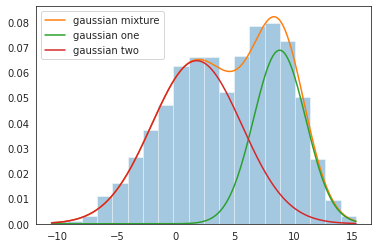

In [7]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();


Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 1.7, σ = 3.8, weight = 0.61
Gaussian 2: μ = 8.8, σ = 2.2, weight = 0.39


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


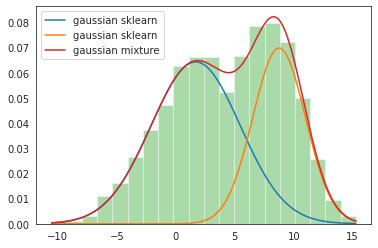

<a id='sec6'></a>
# If you want to explore this subject further

If you want to have a more formal understand of Gaussian mixture, I would recommend:  
https://www.youtube.com/watch?v=4vGiHC35j9s   
if you want to have a less formal, please watch:  
https://www.youtube.com/watch?v=JNlEIEwe-Cg  
EM Demystified: An Expectation-Maximization Tutorial:  
https://vannevar.ece.uw.edu/techsite/papers/documents/UWEETR-2010-0002.pdf  



Hope you liked my notebook (upvote top right), my way to conribute back to this fantastic Kaggle platform and community.

The reason why I needed to understand expectation Maximization is because it was mentioned in research work on biological inspired true artificial intelligence where neuroscience produced a candidate which suggests that several global brain theories might be unified within a free-energy framework: Free Energy Principle (FEP) by Karl Friston: The free-energy principle is an attempt to explain the structure and function of the brain, starting from the very fact that we exist. 
Curious? See my notebook:  
https://www.kaggle.com/charel/learn-by-example-active-inference-in-the-brain-1
 